### In this notebook we'll see, how using dataset library you can write regression models. 

You can see the implementation of the used MyBatch class in [mybatch.py](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/mybatch.py).
Data generation function in [data_generator.py](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_01/data_generator.py)

In [1]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from mybatch import MyBatch
from data_generator import generate_linear_data, \
                           generate_logistic_data, \
                           generate_poisson_data

from dataset import Dataset, DatasetIndex

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

## First we consider linear regression, that allows solving the task where the answer is a continuous variable.
In this example we show how work linear regression, for this we generate data from uniform or normal distribution, multiply with normal distributed weights and the addition of a normally distributed error and try to predict it.

In [3]:
size = 1000
linear_x, linear_y = generate_linear_data(size=size)

Now we create dataset with our class named MyBatch and split it on train/test. We need dataset for create a batch in future, but now the dataset is empty until we load the data unto it. You can read more about now all Dataset works [here](https://github.com/analysiscenter/dataset/tree/master/doc) and about create Dataset [here](https://github.com/analysiscenter/dataset/blob/master/doc/dataset.md).

In [4]:
dataset = Dataset(np.arange(size), batch_class=MyBatch, preloaded=(linear_x, linear_y))
dataset.cv_split()

Create tensorflow session and initialize all variables. In this session we'll train our model.

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

After create a dataset we need to load data and train linear regression model, that implemented into our class.
We can train it on batch of generated data, that we preload before. For this we create __pipeline__, that allow use train and test function out of _MyBatch_ class in one line of code! You can read more [here](https://github.com/analysiscenter/dataset/blob/master/doc/pipeline.md).

In [6]:
dict_params = {'loss': [], 'w': [], 'b': []}

dataset.train.p\
    .train_linear_model(sess, dict_params)\
    .run(batch_size=50, shuffle=True, n_epochs=500)

In [7]:
predict = {'predict': [], 'indices': []}

dataset.test.p\
    .load((linear_x, linear_y))\
    .predict_linear(sess, predict=predict)\
    .run(batch_size=int(size * 0.2), n_epochs=1, shuffle=False)

In last __pipeline__ we test our model. Let's see, how good it do it.

In [8]:
predict = np.array(predict['predict']).reshape(-1)
target = np.array(linear_y[dataset.test.indices]).reshape(-1)

percent = np.mean(np.abs((target - predict) * 100 / target))

print('Percentage of errors: {}%'.format(round(percent, 3)))

Percentage of errors: 0.669%


# Logistic regression solve the task in the case where answer is binary (0 or 1, -1 or 1 and etc)
In this case we generate two clouds of points with different classes and fit logistic regression to predict points class.

In [9]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

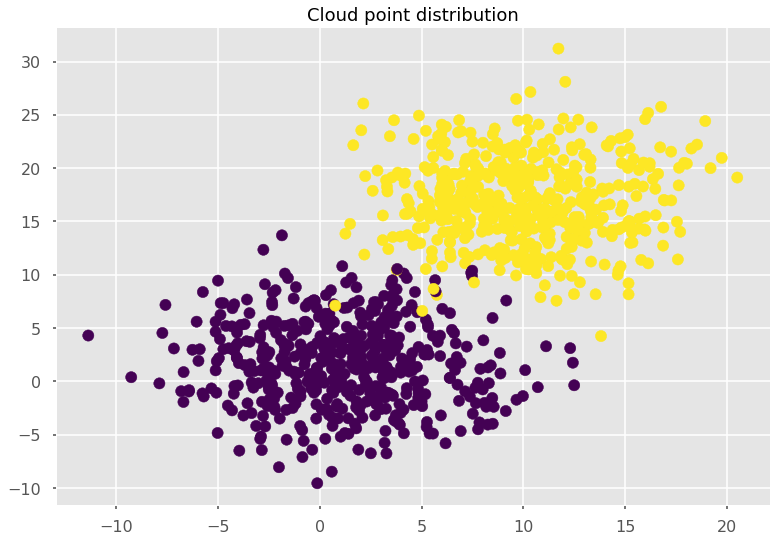

In [10]:
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud point distribution', fontsize=18)

One of the most important thing that you need to know is that it really dosen't matter, which model you want to train and what data you will using for it.The interface always be the same. And now we'll see it.

First of all, we, as in the previues time, create dataset and split it. Only in the preloaded data and the size of dataset was difference. 

In [11]:
dataset = Dataset(np.arange(size), batch_class=MyBatch, preloaded=(logistic_x, logistic_y))
dataset.cv_split()

Like previues time, create session to train new model.

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

As you can see, structure of pipeline was same, change only the name of function, that contain instruction to train model.

In [13]:
dict_params = {'loss': [], 'w': [], 'b': []}

dataset.train.p\
    .train_logistic_model(sess, dict_params)\
    .run(200, shuffle=True, n_epochs=500)

In [14]:
predict = {'predict': [], 'indices': []}

dataset.test.p\
    .predict_logistic(sess, predict=predict)\
    .run(int(size * 0.2), shuffle=False, n_epochs=1)

After train model, we need to check how vell it work.

In [15]:
pred = np.array([0 if i < 0.5 else 1 for i in np.array(predict['predict']).reshape(-1)])
target = np.array(logistic_y[dataset.test.indices].reshape(-1), dtype=np.int32)

percentage = len(np.where(target == pred)[0]) / len(target)
print('Percentage of true values: {}%'.format(round(percentage, 2)))

Percentage of true values: 1.0%


# Poisson regression is used if the answer is count. 
Example show how we can train poisson regression using generate data from poisson regression

In [16]:
size = 500
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size)

Below you can see same cell, as twice before. Only with different names in pipelines.

In [17]:
dataset = Dataset(np.arange(size), batch_class=MyBatch, preloaded=(poisson_x, poisson_y))
dataset.cv_split()

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
dict_params = {'loss': [], 'w': [], 'b': []}

dataset.train.p\
    .train_poisson_model(sess, dict_params)\
    .run(100, shuffle=True, n_epochs=150)

In [20]:
predict = {'predict': [], 'indices': []}

dataset.test.p\
    .predict_poisson(sess, predict=predict)\
    .run(int(size * 0.2), shuffle=False, n_epochs=1)

In [21]:
pred = np.array(predict['predict']).reshape(-1)
pred = np.array([round(i) for i in pred])
target = np.array(poisson_y[dataset.test.indices]).reshape(-1)

true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

percent = np.mean(np.abs(pred - target))/np.mean(target)*100
print('Percentage of errors: {}%'.format(round(percent, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Percentage of errors: 10.853% Variance ratio: 0.898


As you can see, we use three difference function to train and predict. It makes because we want to show you, that no matter what you want to train and what data you want to use for it, dataset always be the same.

But if you need to train many models in one time, not necessary create many function to it. In this example we was create function as @action with model in argument. But there is another way.You can use get_model_by_name('name_model') into @action function. About it you can read [here](https://github.com/analysiscenter/dataset/blob/master/doc/models.md).